In [222]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import sweetviz as sv

In [278]:
_Xtrain = pd.read_csv("x_train.csv", index_col='ID')
_y = pd.read_csv("y_train.csv", index_col='ID')
train = pd.concat([_Xtrain, _y], axis=1)
test = pd.read_csv('x_test.csv', index_col='ID')

In [189]:
print('Number of elements in Sector: ', _Xtrain['SECTOR'].nunique())
print('Number of elements in Industries: ', _Xtrain['INDUSTRY'].nunique())
print('Number of elements in Industries_Group: ', _Xtrain['INDUSTRY_GROUP'].nunique())
print('Number of elements in Sub_Industries: ', _Xtrain['SUB_INDUSTRY'].nunique())

Number of elements in Sector:  12
Number of elements in Industries:  72
Number of elements in Industries_Group:  26
Number of elements in Sub_Industries:  175


In [279]:
for column in train:
    train[column] = train[column].fillna(0)

In [280]:
# Feature engineering
new_features = []

# Conditional aggregated features
shifts = [1,2,3,4]  # Choose some different shifts
statistics = ['mean']  # the type of stat
gb_features_list = [['SECTOR', 'DATE']]

target_features = ['RET']
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for shift in shifts:
            for stat in statistics:
                name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
                feat = f'{target_feature}_{shift}'
                new_features.append(name)
                for data in [train, test]:
                    data[name] = data.groupby(gb_features)[feat].transform(stat)

In [277]:
### didnt use in best submission
shifts = [1]  # Choose some different shifts
statistics = ['mean']  # the type of stat
gb_features_list = [['SECTOR', 'DATE']]
#gb_features_list = [['SECTOR', 'DATE']]

target_features = ['VOLUME']
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for week in shifts:
            for stat in statistics:
                name = f'{target_feature}_{stat}_{gb_features[0]}_1_WEEK_AVG'
                new_features.append(name)
                for data in [train, test]:
                    data[name] = data.groupby(gb_features)[[f'{target_feature}_{day}' for day in range(1,21)]].transform(stat).mean(axis=1)

It seems like the more general statistics are able to filter the noise better. Hence, all stock individual statistics are not further considered at the moment

In [281]:
weeks = 4
statistics = ['mean', 'median', 'std']  # the type of stat
gb_features_list = [['STOCK', 'DATE']]

target_features = ['RET', 'VOLUME']
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for stat in statistics:
            for week in range(weeks):
                name = f'{stat}_{target_feature}_WEEK_{week+1}'
                new_features.append(name)
                for data in [train, test]:
                    if stat == 'mean':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].mean(axis=1)
                    elif stat == 'std':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].std(axis=1)
                    elif stat == 'median':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].median(axis=1)
                    elif stat == 'min':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].min(axis=1)
                    elif stat == 'max':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].max(axis=1)


In [282]:
shifts = [1,2,3,4]  # Choose some different shifts
statistics = ['sum']  # the type of stat
#gb_features_list = [['SECTOR', 'DATE'], ['INDUSTRY_GROUP', 'DATE']]
gb_features_list = [['SECTOR', 'DATE']]
target_features = ['mean_VOLUME_WEEK']
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for shift in shifts:
            for stat in statistics:
                name = f'{target_feature}_{shift}_/total_VOLUME_of_SECTOR_DATE'
                feat = f'{target_feature}_{shift}'
                new_features.append(name)
                for data in [train, test]:
                    data[name] = data[feat]/data.groupby(gb_features)[feat].transform('sum')

In [273]:
###### didnt use that

shifts = [1,2,3,4]  # Choose some different shifts
statistics = ['sum']  # the type of stat
#gb_features_list = [['SECTOR', 'DATE'], ['INDUSTRY_GROUP', 'DATE']]
gb_features_list = [['SECTOR', 'DATE']]
target_features = ['mean_RET_WEEK', 'median_RET_WEEK']
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for shift in shifts:
            for stat in statistics:
                name = f'{target_feature}_{shift}_/total_RET_of_SECTOR_DATE'
                feat = f'{target_feature}_{shift}'
                new_features.append(name)
                for data in [train, test]:
                    data[name] = data[feat]/data.groupby(gb_features)[feat].transform('sum')

In [283]:
target = 'RET'

n_shifts_ret = 5  # If you don't want all the shifts to reduce noise
n_shifts_vol = 5
features = ['RET_%d' % (i + 1) for i in range(n_shifts_ret)]
features += ['VOLUME_%d' % (i + 1) for i in range(n_shifts_vol)]
features += new_features  # The conditional features
train[features].head()

,RET_1,RET_2,RET_3,RET_4,RET_5,VOLUME_1,VOLUME_2,VOLUME_3,VOLUME_4,VOLUME_5,...,median_VOLUME_WEEK_3,median_VOLUME_WEEK_4,std_VOLUME_WEEK_1,std_VOLUME_WEEK_2,std_VOLUME_WEEK_3,std_VOLUME_WEEK_4,mean_VOLUME_WEEK_1_/total_VOLUME_of_SECTOR_DATE,mean_VOLUME_WEEK_2_/total_VOLUME_of_SECTOR_DATE,mean_VOLUME_WEEK_3_/total_VOLUME_of_SECTOR_DATE,mean_VOLUME_WEEK_4_/total_VOLUME_of_SECTOR_DATE
ID,,,,,,,,,,,,,,,,,,,,,
0,-0.015748,-0.015504,0.010972,-0.014672,0.016483,0.147931,0.179183,0.033832,-0.362868,-0.972920,...,-0.369605,-0.000937,0.485623,3.506872,0.750430,0.375799,0.005111,-0.091468,-0.083351,0.003825
1,0.003984,-0.090580,0.018826,-0.025540,-0.038062,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000
2,0.000440,-0.058896,-0.009042,0.024852,0.009354,-0.096282,0.084771,-0.298777,-0.157421,0.091455,...,-0.187444,-0.354333,0.166250,0.468279,0.124713,0.185567,-0.001360,-0.004825,0.002561,0.005859
3,0.031298,0.007756,-0.004632,-0.019677,0.003544,-0.429540,-0.089919,-0.639737,-0.940163,-0.882464,...,-0.540519,-0.562126,0.348658,0.530622,0.728515,0.286219,0.024334,0.010494,0.029748,0.038814
4,0.027273,-0.039302,0.000000,0.000000,0.022321,-0.847155,-0.943033,-1.180629,-1.313896,-1.204398,...,0.271702,0.139086,0.194741,0.414731,8.385123,0.440387,0.104673,-0.610015,0.289063,0.104256


# Model and score

In [284]:
X_train = train[features]
y_train = train[target]
# A quiet large number of trees with low depth to prevent overfits
parameters = {
    'boosting_type': 'rf',
    'n_estimators': 1000,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1, 
    #'feature_fraction': 0.3,
    'feature_fraction': 0.1,
    'objective': 'binary',
    'verbose': -1
}

'''rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}'''
train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates) # Generates the splits of the indexes to use as train / test

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = y_train.loc[local_test_ids]

    #X_local_train = X_local_train.fillna(0)
    #X_local_test = X_local_test.fillna(0)

    model = LGBMClassifier(**parameters)
    #model = RandomForestClassifier(**rf_params)
    model.fit(X_local_train, y_local_train.values.reshape(-1))

    y_local_pred = model.predict_proba(X_local_test)[:, 1]
    
    sub = _Xtrain.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 52.15%
Fold 2 - Accuracy: 50.53%
Fold 3 - Accuracy: 50.45%
Fold 4 - Accuracy: 51.59%
Accuracy: 51.18% [50.46 ; 51.90] (+- 0.72)


<Axes: >

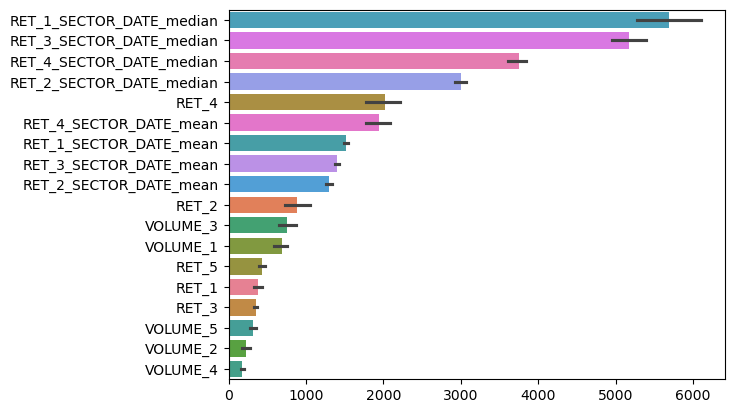

In [228]:
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)

sns.barplot(data=feature_importances, orient='h', order=feature_importances.mean().sort_values(ascending=False).index)

In [229]:
X_test = test[features]

model = LGBMClassifier(**parameters)
model.fit(X_train.fillna(0), y_train)

sub = train.copy()
sub['pred'] = model.predict_proba(X_train.fillna(0))[:,1]
y_pred_train = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values
print(accuracy_score(y_pred_train,y_train))

y_pred = model.predict_proba(X_test.fillna(0))[:, 1]

sub = test.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = test.index
submission.name = target

submission.to_csv('./y_test.csv', index=True, header=True)

0.5619990683118528
